# Data Loading

Load the dataset and inspect.

In [2]:
# Import all dependencies
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import pandas as pd
from pandas.api.types import CategoricalDtype

import numpy as np

from sklearn import metrics
from sklearn.metrics import recall_score, make_scorer
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.feature_selection import SelectPercentile, chi2, SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree


from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

# Import the data set
full = pd.read_csv('bank-additional-full.csv', sep=';')
df = pd.read_csv('bank-additional.csv', sep=';')

df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,...,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no
1,39,services,single,high.school,no,no,no,telephone,may,fri,...,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
2,25,services,married,high.school,no,yes,no,telephone,jun,wed,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,no
3,38,services,married,basic.9y,no,unknown,unknown,telephone,jun,fri,...,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,no
4,47,admin.,married,university.degree,no,yes,no,cellular,nov,mon,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,no


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4119 entries, 0 to 4118
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             4119 non-null   int64  
 1   job             4119 non-null   object 
 2   marital         4119 non-null   object 
 3   education       4119 non-null   object 
 4   default         4119 non-null   object 
 5   housing         4119 non-null   object 
 6   loan            4119 non-null   object 
 7   contact         4119 non-null   object 
 8   month           4119 non-null   object 
 9   day_of_week     4119 non-null   object 
 10  duration        4119 non-null   int64  
 11  campaign        4119 non-null   int64  
 12  pdays           4119 non-null   int64  
 13  previous        4119 non-null   int64  
 14  poutcome        4119 non-null   object 
 15  emp.var.rate    4119 non-null   float64
 16  cons.price.idx  4119 non-null   float64
 17  cons.conf.idx   4119 non-null   f

# Data Cleaning

Let's clean up some data, based on the column descriptions

## Education
Let's look at the value distribution

In [4]:
df['education'].value_counts().sort_index()

education
basic.4y                429
basic.6y                228
basic.9y                574
high.school             921
illiterate                1
professional.course     535
university.degree      1264
unknown                 167
Name: count, dtype: int64

In [5]:
# drop the rows with illiterate or unknown education from df dataframe and get number of rows dropped in count variable
df.drop(df[(df['education'] == 'illiterate') | (df['education'] == 'unknown')].index, inplace=True)

## Marital, Default, Housing and Loan
These contain rows with value "unknown" with very low counts. Remove them

In [6]:
def count_unknowns(df, column):
    return df[df[column] == 'unknown'].shape[0]

print(f'Marital unknown count: {count_unknowns(df, "marital")}')
print(f'Default unknown count: {count_unknowns(df, "default")}')
print(f'Housing unknown count: {count_unknowns(df, "housing")}')
print(f'Loan unknown count: {count_unknowns(df, "loan")}')

Marital unknown count: 11
Default unknown count: 755
Housing unknown count: 104
Loan unknown count: 104


In [7]:
df.drop(df[df['marital'] == 'unknown'].index, inplace=True)
df.drop(df[df['default'] == 'unknown'].index, inplace=True)
df.drop(df[df['housing'] == 'unknown'].index, inplace=True)
df.drop(df[df['loan'] == 'unknown'].index, inplace=True)

print(f'Marital unknown count: {count_unknowns(df, "marital")}')
print(f'Default unknown count: {count_unknowns(df, "default")}')
print(f'Housing unknown count: {count_unknowns(df, "housing")}')
print(f'Loan unknown count: {count_unknowns(df, "loan")}')

Marital unknown count: 0
Default unknown count: 0
Housing unknown count: 0
Loan unknown count: 0


We will also turn these categorical into booleans

In [8]:
df['default'].replace('no', 0, inplace=True)
df['default'].replace('yes', 1, inplace=True)
df['housing'].replace('no', 0, inplace=True)
df['housing'].replace('yes', 1, inplace=True)
df['loan'].replace('no', 0, inplace=True)
df['loan'].replace('yes', 1, inplace=True)

## Duration
We will drop this column as recommended by the notes included with the dataset.

In [9]:
df.drop('duration', axis=1, inplace=True)

## Pdays
Number of days that passed by after the client was last contacted from a previous campaign. The distribution of this variable is very unequal, with 95.4% of values being 999. We will remove this
column.  

In [10]:
df.drop('pdays', axis=1, inplace=True)

## Poutcome
Most values are 'nonexistent', so I think we should drop this column altogether

In [11]:
non_existent = df[df['poutcome'] == 'nonexistent'].shape[0]
print(f'Nonexistent count: {non_existent}')

# Delete
df.drop('poutcome', axis=1, inplace=True)

Nonexistent count: 2613


## Target variable (Y)

This variable is a boolean, so we will convert it to 0 and 1.

In [12]:
df['y'].replace('no', 0, inplace=True)
df['y'].replace('yes', 1, inplace=True)

# Exploratory Data Analysis

## Automatic Profiling using pandas-profiling

We will use a tool called pandas-profiling (ydata_profiling) to generate a report. This will be out starting point, and we will explore further from there.

In [13]:
# Profiling test
# from ydata_profiling import ProfileReport
# 
# profile = ProfileReport(df, title="Pandas Profiling Report")
# profile.to_file("ydata_report.html")

## Correlations

The following correlation matrix was generated for us. Let's explore some of these.

<img src="images/correlations.png" alt="Correlations Heatmap" width="1300">

## Age

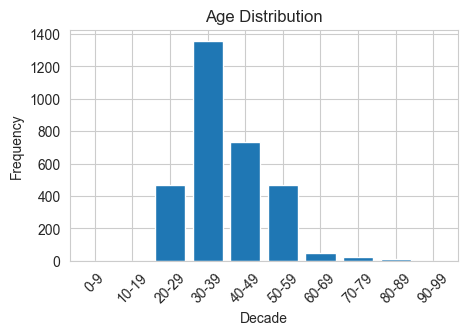

In [14]:
# Define the bin edges for decades (adjust as needed)
bin_edges = [0, 9, 19, 29, 39, 49, 59, 69, 79, 89, 99]

# Use pd.cut() to categorize ages into decades
df['decade'] = pd.cut(df['age'], bins=bin_edges, labels=[f'{i}-{i+9}' for i in range(0, 100, 10)])

# Plot the histogram
plt.figure(figsize=(5,3))
df['decade'].value_counts().sort_index().plot(kind='bar', width=0.8)

# Customize the plot
plt.xlabel('Decade')
plt.ylabel('Frequency')
plt.title('Age Distribution')
plt.xticks(rotation=45)
plt.show();

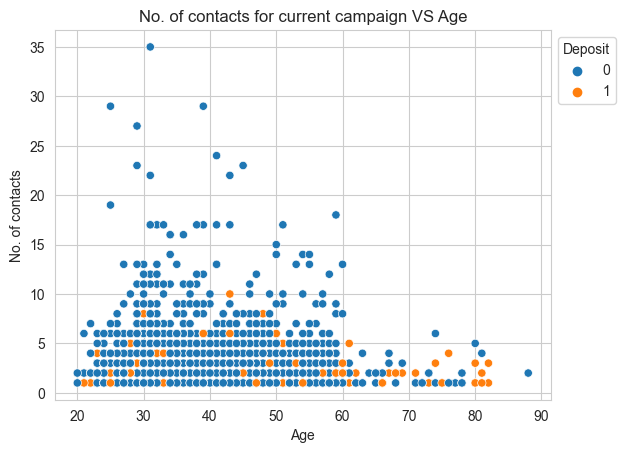

In [15]:
ax = sns.scatterplot(data=df, x='age', y='campaign', hue='y')
ax.set(ylabel='No. of contacts', xlabel='Age', title="No. of contacts for current campaign VS Age")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), title='Deposit')

From what we can see, it seems it takes less contacts to get a positive response from older customers

# Preprocessing

## Fix Data types

First let's make sure our data types are correct, as we will use the `make_column_selector` later to do Feature selection.

In [16]:
# Look through the dataframe columns and convert those with type 'object' to type 'category'
for column in df.columns:
    if df[column].dtype == 'object':
        df[column] = df[column].astype('category')

# Yes/No (1/0) columns as categories
df['y'] = df['y'].astype('category')
df['default'] = df['default'].astype('category')
df['loan'] = df['loan'].astype('category')

# Set order on some categories. 
education_cats = [
    'basic.4y',
    'basic.6y',
    'basic.9y',
    'high.school',
    'professional.course',
    'university.degree'
]

# Education
education_type = CategoricalDtype(categories=education_cats, ordered=True)
df['education'] = df['education'].astype(education_type)

# Month
month_cats = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
month_type = CategoricalDtype(categories=month_cats, ordered=True)
df['month'] = df['month'].astype(month_type)

# Day of the Week
day_of_week_cats = ['mon', 'tue', 'wed', 'thu', 'fri']
day_of_week_type = CategoricalDtype(categories=day_of_week_cats, ordered=True)
df['day_of_week'] = df['day_of_week'].astype(day_of_week_type)

df.info()

df.job.value_counts()

<class 'pandas.core.frame.DataFrame'>
Index: 3106 entries, 0 to 4118
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             3106 non-null   int64   
 1   job             3106 non-null   category
 2   marital         3106 non-null   category
 3   education       3106 non-null   category
 4   default         3106 non-null   category
 5   housing         3106 non-null   int64   
 6   loan            3106 non-null   category
 7   contact         3106 non-null   category
 8   month           3106 non-null   category
 9   day_of_week     3106 non-null   category
 10  campaign        3106 non-null   int64   
 11  previous        3106 non-null   int64   
 12  emp.var.rate    3106 non-null   float64 
 13  cons.price.idx  3106 non-null   float64 
 14  cons.conf.idx   3106 non-null   float64 
 15  euribor3m       3106 non-null   float64 
 16  nr.employed     3106 non-null   float64 
 17  y               310

job
admin.           854
technician       573
blue-collar      554
services         276
management       265
self-employed    126
retired          118
entrepreneur     107
unemployed        86
housemaid         75
student           55
unknown           17
Name: count, dtype: int64

## Scale and Transform

* Numerical columns are scaled using StandardScaler
* Numerical columns dont need imputation because there are no missing values.
* Categorical columns are encoded using OneHotEncoder
* Ordinal Categorical columns are encoded using OrdinalEncoder

In [17]:
# Drop extra column used for graphs.
df.drop(['decade'], axis = 1, inplace = True)

# A selector for all of our numeric columns.
numeric_selector = make_column_selector(dtype_include=['int64', 'float64'])

# Select all categories
category_selector = make_column_selector(dtype_include='category')
category_columns = category_selector(df)

# Filter out the ordinal categories 
ordinal_category_columns = ['education', 'month', 'day_of_week']
categories = [col for col in category_columns if col not in ordinal_category_columns + ['y']]
 
# Get the ordered category lists.
ordinal_categories = [df[col].cat.categories.tolist() for col in ordinal_category_columns]
regular_categories = [df[col].cat.categories.tolist() for col in categories]

# Put together the column transformer
transformer = make_column_transformer(
    (StandardScaler(), numeric_selector),
    (OneHotEncoder(drop = 'first', categories = regular_categories), categories),
    (OrdinalEncoder(categories = ordinal_categories), ordinal_category_columns),
)

transformer

ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x15f5f9f50>),
                                ('onehotencoder',
                                 OneHotEncoder(categories=[['admin.',
                                                            'blue-collar',
                                                            'entrepreneur',
                                                            'housemaid',
                                                            'management',
                                                            'retired',
                                                            'self-employed',
                                                            'services',
                                                            'student',
                                                            'technician',
                                                            'unemployed',
                                                            'unknown'],
                                                           ['divorced',
                                                            '...
                                                            'telephone']],
                                               drop='first'),
                                 ['job', 'marital', 'default', 'loan',
                                  'contact']),
                                ('ordinalencoder',
                                 OrdinalEncoder(categories=[['basic.4y',
                                                             'basic.6y',
                                                             'basic.9y',
                                                             'high.school',
                                                             'professional.course',
                                                             'university.degree'],
                                                            ['jan', 'feb',
                                                             'mar', 'apr',
                                                             'may', 'jun',
                                                             'jul', 'aug',
                                                             'sep', 'oct',
                                                             'nov', 'dec'],
                                                            ['mon', 'tue',
                                                             'wed', 'thu',
                                                             'fri']]),
                                 ['education', 'month', 'day_of_week'])])

## Split the data

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['y'], axis = 1), 
    df['y'], 
    random_state = 442, 
    stratify = df['y']
)

# Modeling

## Feature Extraction

We will use a LogisticRegression estimator to select our features.

In [19]:
estimator = LogisticRegression(penalty='l1', solver = 'liblinear', random_state = 42)
extractor = SelectFromModel(estimator)


## Logistic Regression

### Initial Model

Let's try the basic Logistic Regression

In [20]:
lr_pipe = ImbPipeline([
    ('transformer', transformer),
    ('selector', extractor),
    ('over', SMOTE()),
    ('logistic_regression', LogisticRegression(random_state = 42, max_iter = 1000))
])

# Fit the model
lr_pipe.fit(X_train, y_train)

# Score the model
lrp_acc = lr_pipe.score(X_test, y_test)

# Print the accuracy
print(f'Accuracy: {lrp_acc}')

Accuracy: 0.8005148005148005


In [21]:
def prediction_metrics(estimator):
    # Make predictions
    y_pred = estimator.predict(X_test)
    y_pred_proba = estimator.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    accuracy = metrics.accuracy_score(y_test, y_pred)
    precision = metrics.precision_score(y_test, y_pred)
    recall = metrics.recall_score(y_test, y_pred)
    f1 = metrics.f1_score(y_test, y_pred)
    roc_auc = metrics.roc_auc_score(y_test, y_pred_proba)    
    
    # Create a DataFrame with the metrics
    return pd.DataFrame({
        'Accuracy': [accuracy],
        'Precision': [precision],
        'Recall': [recall],
        'F1 Score': [f1],
        'ROC AUC': [roc_auc]
    })

# Print the DataFrame
prediction_metrics(lr_pipe)

,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,0.800515,0.319767,0.591398,0.415094,0.783327


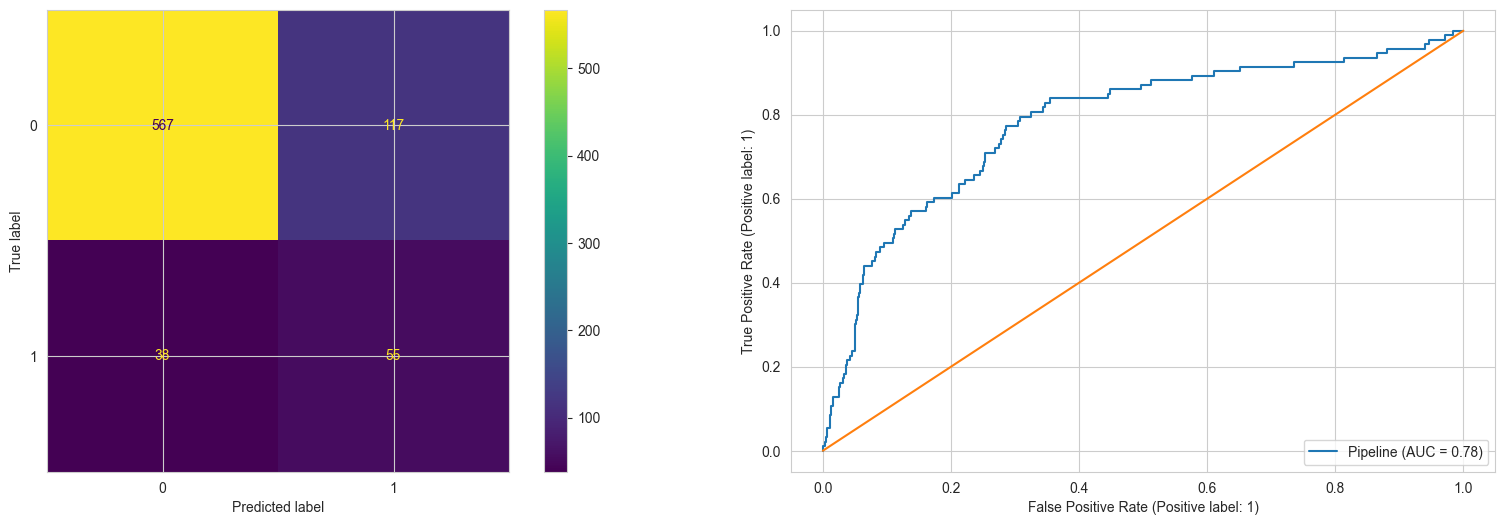

In [22]:
def plot_confussion_and_roc(estimator):
    fig, ax = plt.subplots(1, 2, figsize = (20, 6))
    ConfusionMatrixDisplay.from_estimator(estimator, X_test, y_test, ax = ax[0])
    RocCurveDisplay.from_estimator(estimator, X_test, y_test, ax = ax[1])
    ax[1].plot(np.array([0, 1]), np.array([0, 1]))
    
plot_confussion_and_roc(lr_pipe) 

### Feature Importance

In [23]:
feature_names = lr_pipe.named_steps['transformer'].get_feature_names_out() 
selected_features =feature_names[ [int(i[1:]) for i in lr_pipe.named_steps['selector'].get_feature_names_out()]]
clean_names = [i.split('__')[-1] for i in selected_features]
coef_df = pd.DataFrame({'feature': clean_names, 'coefs': lr_pipe.named_steps['logistic_regression'].coef_[0]})
coef_df['coefs'] = coef_df['coefs'].apply(abs)
coef_df = coef_df.sort_values(by = 'coefs', ascending = False)
coef_df

,feature,coefs
4,emp.var.rate,2.257305
18,contact_telephone,1.633609
7,euribor3m,1.193760
5,cons.price.idx,1.106345
14,job_unknown,1.039570
12,job_retired,0.865242
11,job_management,0.779669
13,job_services,0.464954
16,marital_single,0.396561
6,cons.conf.idx,0.389240


### Optimization

Since we care more about correctly predicting true positives, we will use recall as our scoring metric.

In [24]:
param_grid = {
    'logistic_regression__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'logistic_regression__penalty': ['l1', 'l2'],  # 'l1' is not supported by the 'lbfgs' solver, which is default
    'logistic_regression__solver': ['liblinear']  # Uncomment this line if using 'l1' penalty
}

# Define the scorer
scorer = make_scorer(recall_score)

# Set up the grid search with cross-validation
grid_search = GridSearchCV(lr_pipe, param_grid=param_grid, scoring=scorer, cv=5)

# Fit the grid search to the data
# X_train and y_train should be your data
grid_search.fit(X_train, y_train)

# The best hyperparameters and the best recall can be accessed after fitting
best_params = grid_search.best_params_
best_recall = grid_search.best_score_

print(f"Best parameters: {best_params}")
print(f"Best recall: {best_recall}")

Best parameters: {'logistic_regression__C': 0.01, 'logistic_regression__penalty': 'l1', 'logistic_regression__solver': 'liblinear'}
Best recall: 0.7345454545454546


In [25]:
prediction_metrics(grid_search.best_estimator_)

,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,0.725869,0.272727,0.774194,0.403361,0.763402


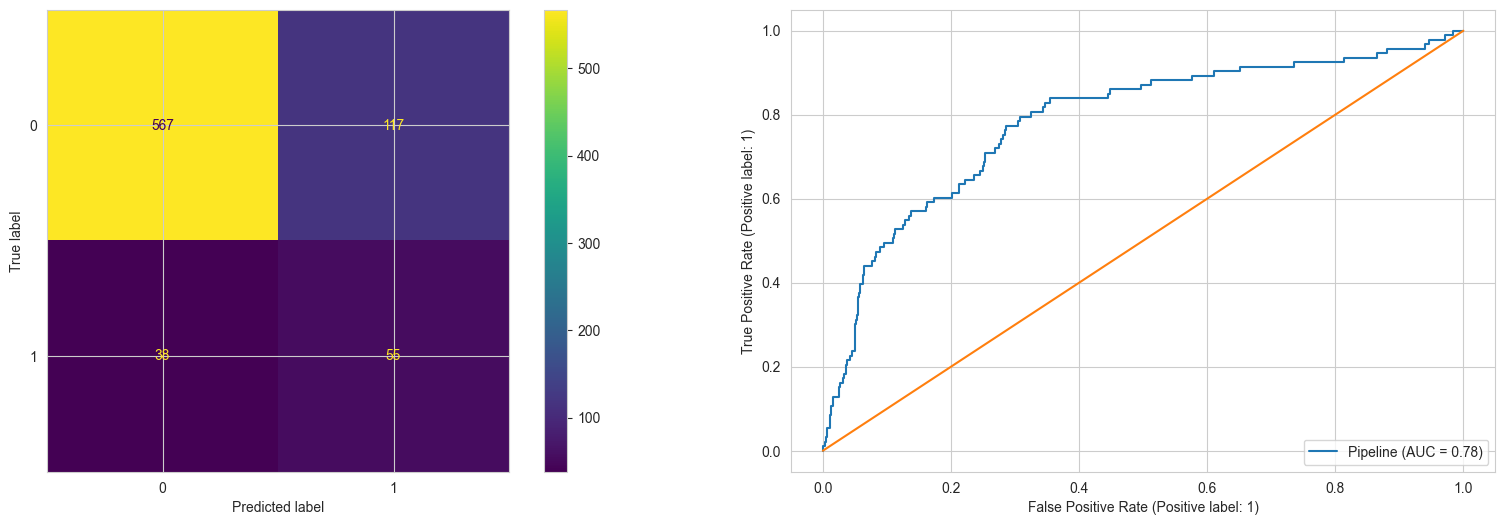

In [26]:
plot_confussion_and_roc(lr_pipe) 

TODO: Try Different Kernels (module 16)

## KNN

In [27]:
knn_pipe = Pipeline([
    ('transformer', transformer),
    ('selector', extractor),
    ('knn', KNeighborsClassifier())
])

params2 = {'knn__n_neighbors': np.arange(15, 20),
          'knn__weights': ['uniform', 'distance'],
          'knn__p': [1, 2]}

weight_grid = GridSearchCV(knn_pipe, param_grid = params2, cv = 5)

weight_grid.fit(X_train, y_train)

weights_acc = weight_grid.score(X_test, y_test)

print(f'The best accuracy is {weights_acc:.4f}')
print(f'The number of models evaluated {len(weight_grid.cv_results_["mean_test_score"]):.3f}')
print(weight_grid.best_params_)

# Get the best model 
model = weight_grid.best_estimator_

# Score the model
prediction_metrics(model)

The best accuracy is 0.8829
The number of models evaluated 20.000
{'knn__n_neighbors': 17, 'knn__p': 1, 'knn__weights': 'distance'}


,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,0.882883,0.529412,0.193548,0.283465,0.739452


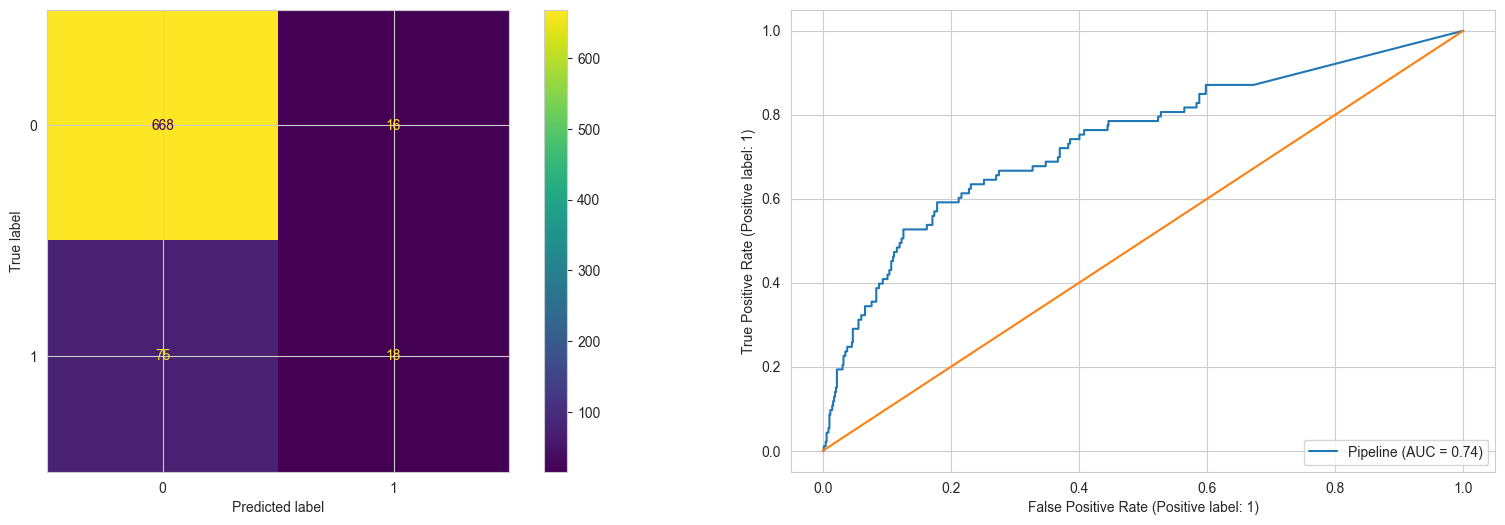

In [28]:
plot_confussion_and_roc(model)

In [29]:
# For binary classification, when can adjust the threshold using the predict_proba method
base_probs = model.predict_proba(X_test)
# pd.DataFrame(base_probs, columns = ['p_no', 'p_yes']).sample(10)

# Minifize the false negatives by adjusting the threshold
threshold = .8
stricter_preds = np.where(base_probs[:, 0] > threshold, 0, 1)
stricter_fn = 0
for i, j in zip(stricter_preds, y_test):
    if i == 0:
        if j == 1:
            stricter_fn += 1

print(f'There are {stricter_fn} false negatives when the threshold is {threshold}')

There are 44 false negatives when the threshold is 0.8


## Decision Tree

### Initial Model

In [30]:
model = Pipeline([
    ('transformer', transformer),
    ('selector', extractor),
    ('dtree', DecisionTreeClassifier(
        random_state=42, 
        criterion='entropy',
        class_weight='balanced',
        min_samples_split=100,
        min_samples_leaf=10,
        min_impurity_decrease=0.0001
    ))
])

model.fit(X_train, y_train)
print(model['dtree'].get_depth())
acc = model.score(X_test, y_test)
# Score the model
prediction_metrics(model)

18


,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,0.715573,0.244,0.655914,0.355685,0.732488


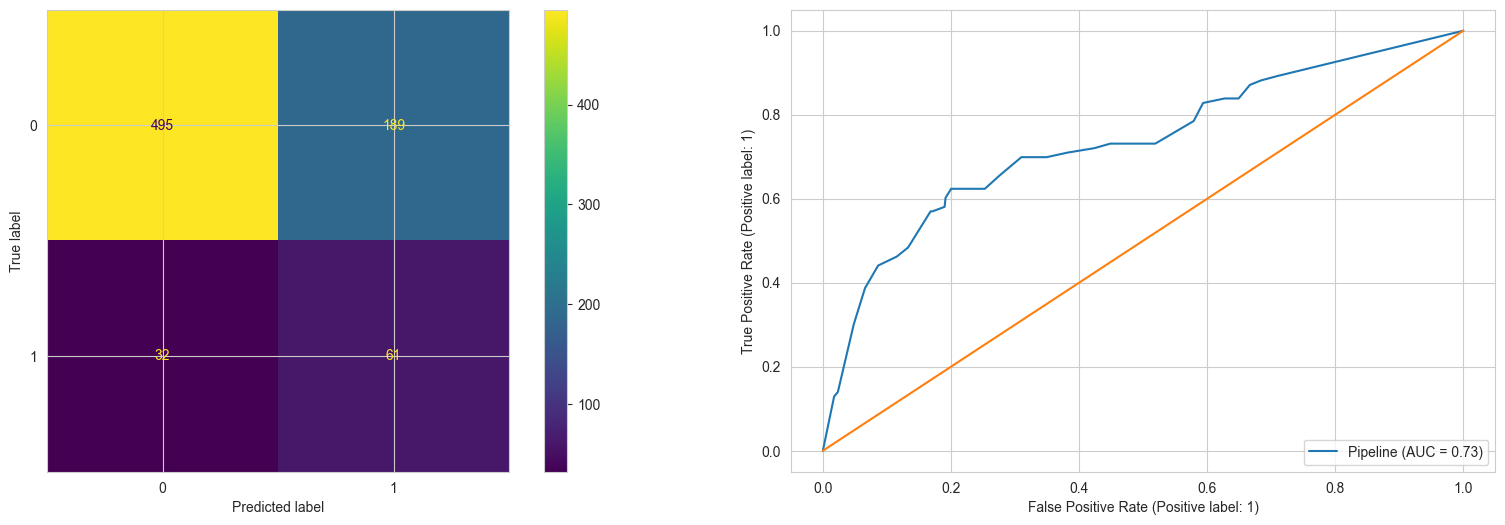

In [31]:
plot_confussion_and_roc(model)

### Optimization

In [32]:
dtree_pipe = ImbPipeline([
    ('transformer', transformer),
    ('smote', SMOTE(random_state=42)),
    ('selector', extractor),
    ('dtree', DecisionTreeClassifier(random_state=42, class_weight='balanced'))
])

params = {
    'dtree__min_impurity_decrease': [0.0008, 0.0009, 0.00095, 0.001],
    'dtree__max_depth': [5, 10, 15],
    'dtree__min_samples_split': [30, 40, 50],
    'dtree__min_samples_leaf': [24, 25, 26, 27],
    'dtree__criterion': ['gini', 'entropy'],
}

dtree_grid = GridSearchCV(dtree_pipe, param_grid = params, cv = 5, scoring = 'recall')
dtree_grid.fit(X_train, y_train)

acc = dtree_grid.score(X_test, y_test)

print(f'The best recall is {acc:.4f}')
print(f'The number of models evaluated {len(dtree_grid.cv_results_["mean_test_score"]):.3f}')
print(dtree_grid.best_params_)

# Get the best model 
model = dtree_grid.best_estimator_
# Score the model
prediction_metrics(model)

The best recall is 0.5161
The number of models evaluated 288.000
{'dtree__criterion': 'gini', 'dtree__max_depth': 10, 'dtree__min_impurity_decrease': 0.001, 'dtree__min_samples_leaf': 26, 'dtree__min_samples_split': 30}


,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,0.830116,0.355556,0.516129,0.421053,0.739664


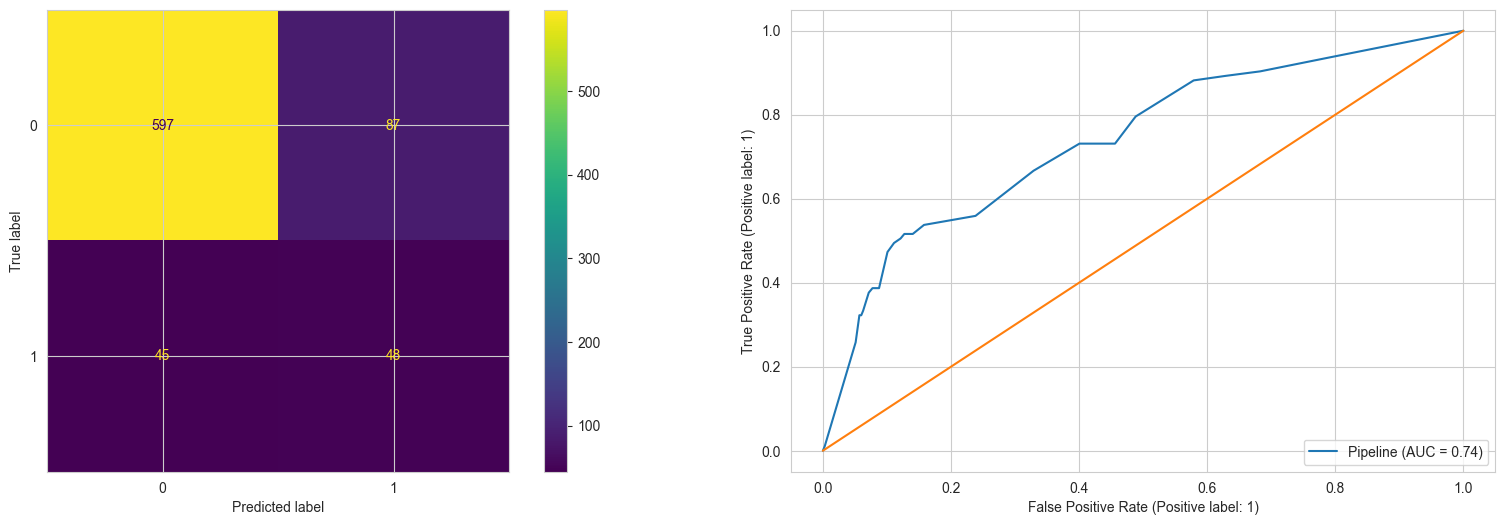

In [33]:
plot_confussion_and_roc(model)